In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

breastcancer = '../datasets/diabetes.csv'
df = pd.read_csv(breastcancer)

# Reduce the dataframe size by sampling 1/3 of the data
df = df.sample(frac=1/3, random_state=1)  # random_state for reproducibility

# Separate the dataset into features (X) and target label (y)
y = df['Outcome']  # Target label: diagnosis
X = df.drop('Outcome', axis=1)  # Features: all other columns

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Set parameters for the quantum feature map
feature_dimension = 2  # Number of features used in the quantum feature map
reps = 2  # Number of repetitions of the feature map circuit
entanglement = 'linear'  # Type of entanglement in the quantum circuit

In [2]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [4]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

Classical SVC on the training dataset: 0.86
Classical SVC on the test dataset:     0.65


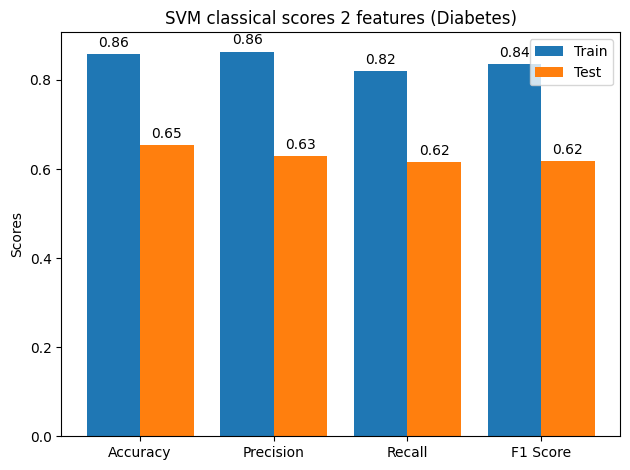

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming `svc` is your trained Support Vector Classifier model
# First, get predictions for both training and testing datasets
train_predictions = svc.predict(train_features)
test_predictions = svc.predict(test_features)

# Calculate accuracy (redundant here as you already have scores but included for completeness)
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate precision, recall, and F1-score for both sets
train_precision = precision_score(train_labels, train_predictions, average='macro')
test_precision = precision_score(test_labels, test_predictions, average='macro')
train_recall = recall_score(train_labels, train_predictions, average='macro')
test_recall = recall_score(test_labels, test_predictions, average='macro')
train_f1 = f1_score(train_labels, train_predictions, average='macro')
test_f1 = f1_score(test_labels, test_predictions, average='macro')

# Printing scores for verification
print(f"Classical SVC on the training dataset: {train_accuracy:.2f}")
print(f"Classical SVC on the test dataset:     {test_accuracy:.2f}")

# Now plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = range(len(metrics))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_scores, 0.4, label='Train')
rects2 = ax.bar([p + 0.4 for p in x], test_scores, 0.4, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SVM classical scores 2 features (Diabetes)')
ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

# Function to add a label on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


Num of features in datatset: 8


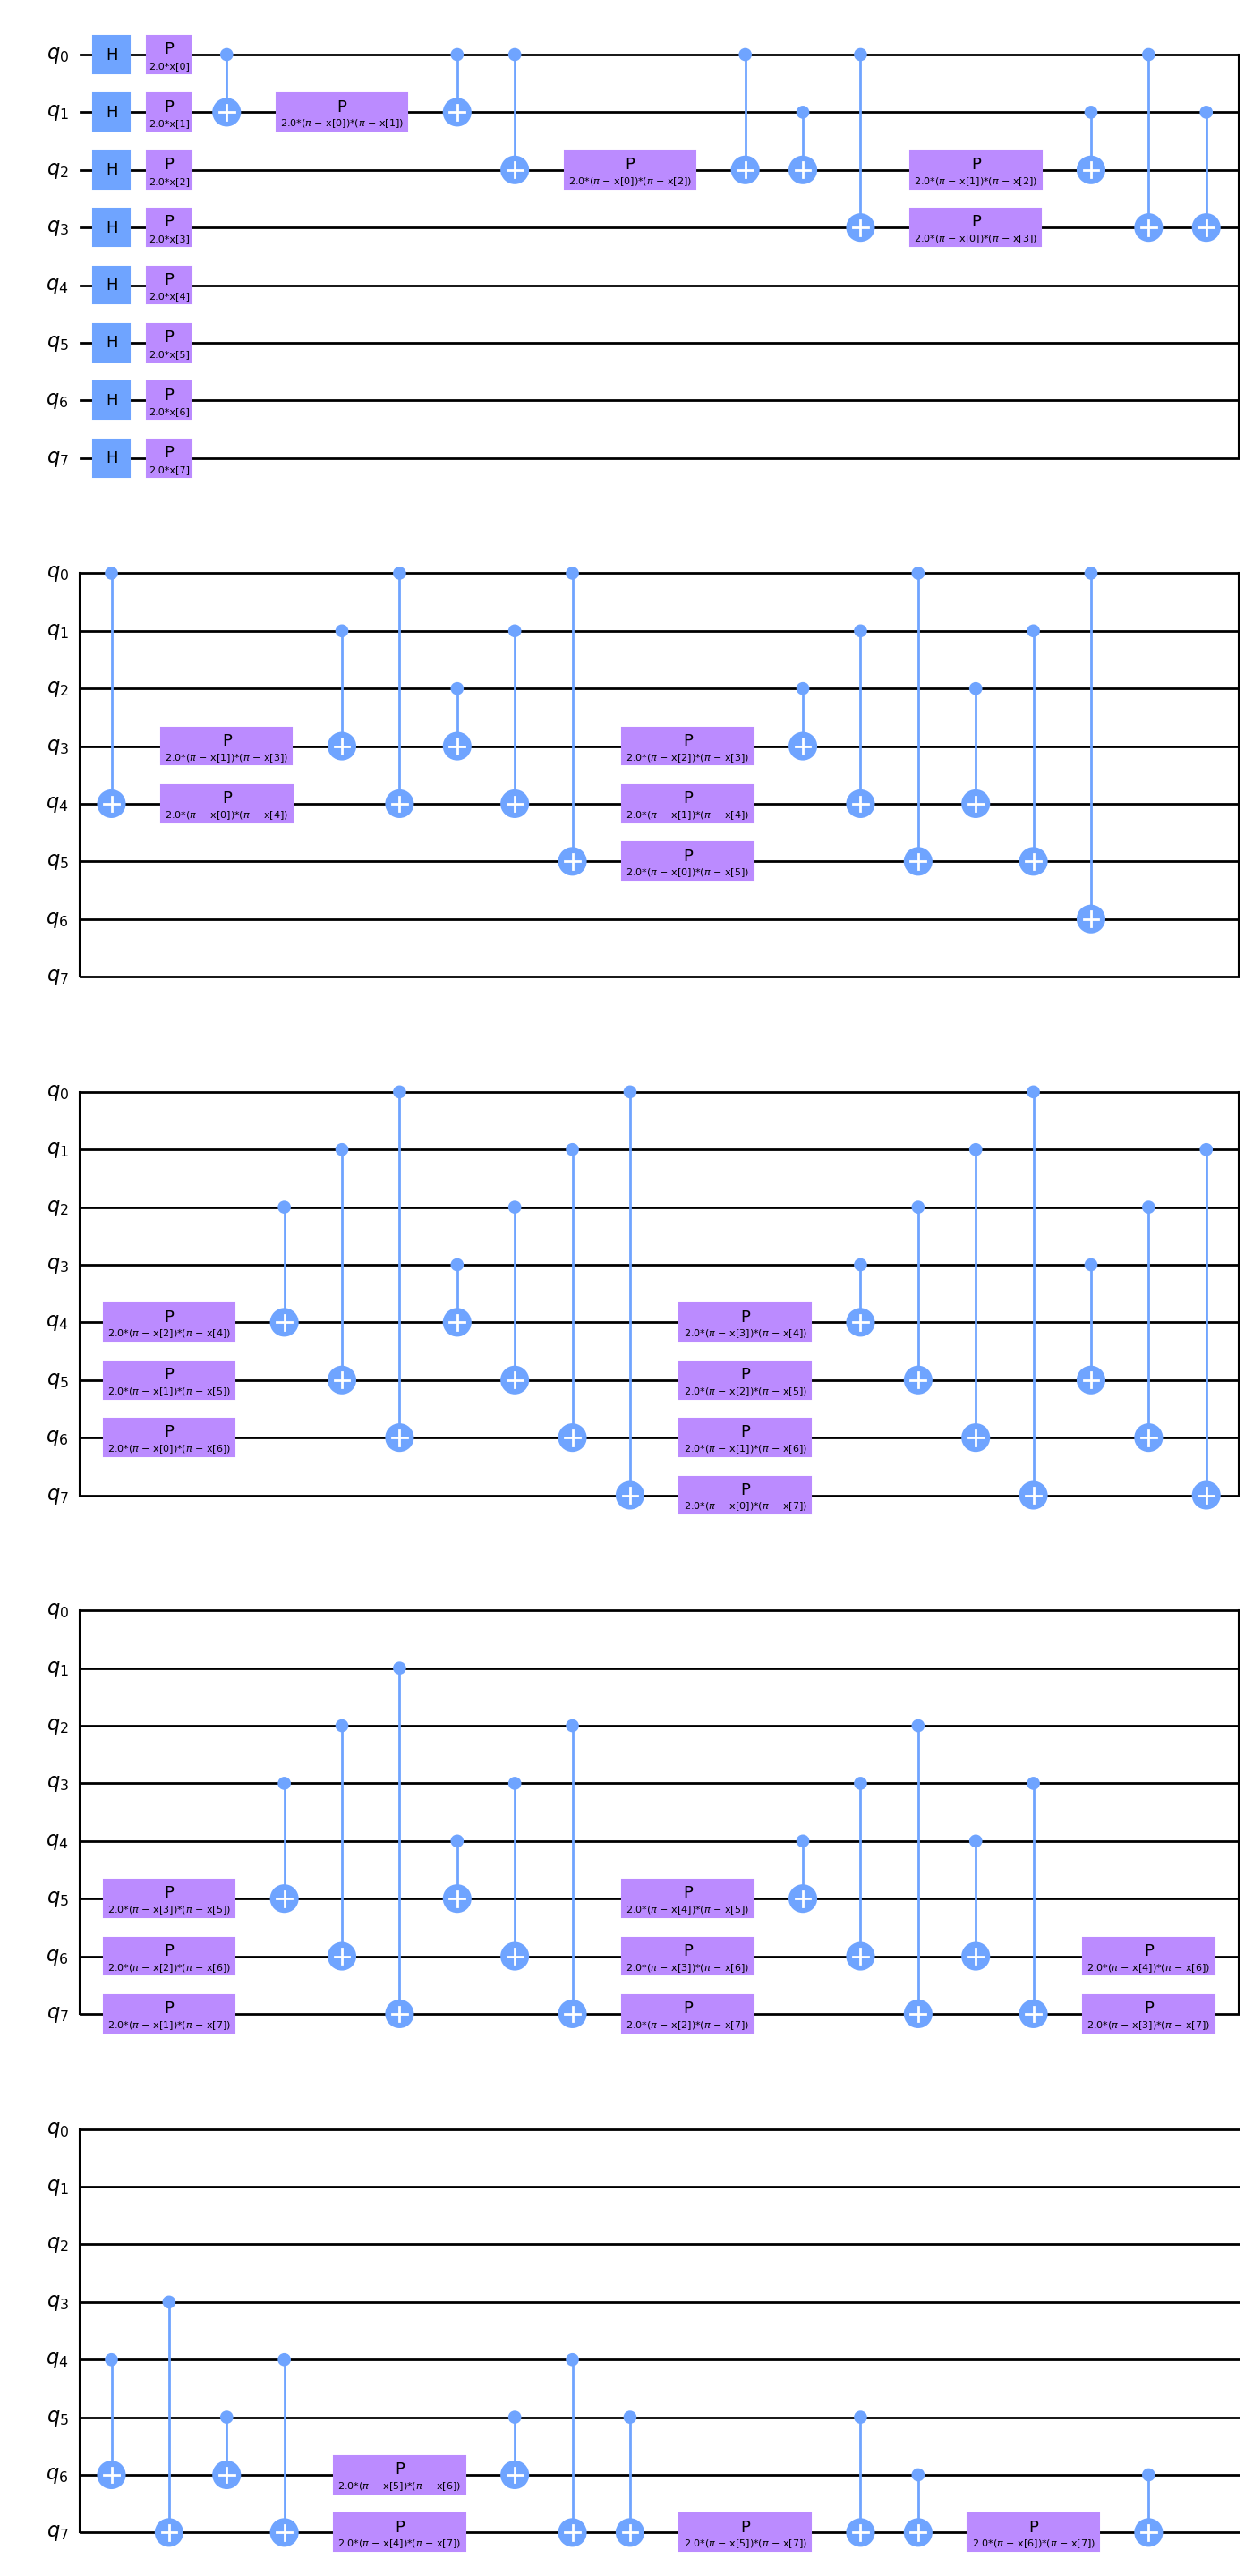

In [6]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X.shape[1]

print("Num of features in datatset:", num_features)

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [8]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
# from qiskit.providers.aer import Aer

# from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, SPSA, L_BFGS_B

# Define the quantum instance
# backend = Aer.get_backend('aer_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024)

# Define feature maps
feature_mapZZ = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_mapZ = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_mapPauli = PauliFeatureMap(feature_dimension=num_features, reps=1)
# num_features = features.shape[1]
# Define ansatzes
ansatzRealAmp = RealAmplitudes(num_qubits=num_features, reps=3)
ansatzEffSU = EfficientSU2(num_qubits=num_features, reps=3)

# Define optimizers
optimizerCoby = COBYLA(maxiter=40)
optimizerSpsa = SPSA(maxiter=40)
optimizerL = L_BFGS_B(maxiter=40)


# Define feature maps, ansatzes, and optimizers lists
feature_maps = [feature_mapZZ, feature_mapZ, feature_mapPauli]
ansatzes = [ansatzRealAmp, ansatzEffSU]
optimizers = [optimizerCoby, optimizerSpsa, optimizerL]


In [11]:
from matplotlib import pyplot as plt
import os
from qiskit_machine_learning.algorithms import VQC
from sklearn.metrics import precision_score, recall_score, f1_score

def callback_graph2(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

plot_dir = "diabetes_vqc_plots_scores"
os.makedirs(plot_dir, exist_ok=True)

# Assuming train_features, train_labels, test_features, and test_labels are predefined
# Iterate through all combinations
for feature_map in feature_maps:
    for ansatz in ansatzes:
        for optimizer in optimizers:
            # Reset objective function values storage
            objective_func_vals = []

            # Initialize VQC with the specific combination
            vqc = VQC(optimizer=optimizer, feature_map=feature_map, ansatz=ansatz, callback=callback_graph2)

            # Train VQC
            vqc.fit(train_features, train_labels)

            # Predictions for metrics calculation
            train_predictions = vqc.predict(train_features)
            test_predictions = vqc.predict(test_features)

            # Calculate scores
            train_accuracy = vqc.score(train_features, train_labels)
            test_accuracy = vqc.score(test_features, test_labels)
            train_precision = precision_score(train_labels, train_predictions, average='macro')
            test_precision = precision_score(test_labels, test_predictions, average='macro')
            train_recall = recall_score(train_labels, train_predictions, average='macro')
            test_recall = recall_score(test_labels, test_predictions, average='macro')
            train_f1 = f1_score(train_labels, train_predictions, average='macro')
            test_f1 = f1_score(test_labels, test_predictions, average='macro')

            # Plotting for this specific combination after training
            plt.figure(figsize=(12, 6))
            plt.plot(objective_func_vals, label=f'{feature_map.name}-{ansatz.name}-{optimizer.__class__.__name__}')
            plt.title(f'VQC Training - {feature_map.name}, {ansatz.name}, {optimizer.__class__.__name__}')
            plt.xlabel('Iteration')
            plt.ylabel('Objective Function Value')
            plt.legend()
            plt.grid(True)

            # Save the plot to a file
            plot_filename = f"{plot_dir}/{feature_map.name}_{ansatz.name}_{optimizer.__class__.__name__}.png"
            plt.savefig(plot_filename)
            plt.close()

            # Writing scores to a text file
            scores_filename = f"{plot_dir}/{feature_map.name}_{ansatz.name}_{optimizer.__class__.__name__}_scores.txt"
            with open(scores_filename, 'w') as file:
                file.write("Performance Metrics\n")
                file.write("========================================\n")
                file.write(f"Training Scores - Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}\n")
                file.write(f"Test Scores - Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}\n")

            # Console output for confirmation
            print(f"Saved plot to {plot_filename} and scores to {scores_filename}.")


Saved plot to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_COBYLA.png and scores to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_COBYLA_scores.txt.
Saved plot to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_SPSA.png and scores to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_SPSA_scores.txt.
Saved plot to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_L_BFGS_B.png and scores to diabetes_vqc_plots_scores/ZZFeatureMap_RealAmplitudes_L_BFGS_B_scores.txt.
Saved plot to diabetes_vqc_plots_scores/ZZFeatureMap_EfficientSU2_COBYLA.png and scores to diabetes_vqc_plots_scores/ZZFeatureMap_EfficientSU2_COBYLA_scores.txt.
Saved plot to diabetes_vqc_plots_scores/ZZFeatureMap_EfficientSU2_SPSA.png and scores to diabetes_vqc_plots_scores/ZZFeatureMap_EfficientSU2_SPSA_scores.txt.
